In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 20, 10

In [3]:
from sklearn.naive_bayes import *
from sklearn.ensemble import *

In [4]:
from naive_bayes_classifier.load_data import str2word_bag
from naive_bayes_classifier.configure import *
from back_test import *
from utils import *

In [5]:
import pickle
import pandas as pd
import numpy as np

In [6]:
import datetime as dt

## Accquiring Speeches From the Fed's Website

Using web crawler, can be found in *data_crawler.py*

In [7]:
rate_se, rst_lst = load_data()

## 5-Year Effective Treasury Yield Change from 2004 til Now  

In [8]:
def display_impactful_speech(rst_lst_=rst_lst, rates = rate_se, time_window=10, show_ratio=0.2):
    speech_dates = pd.to_datetime([rst_lst[i][1] for i in range(len(rst_lst))])
    speech_dates = pd.Series(speech_dates)
    speech_dates.sort_values(inplace=True)
    speech_dates = speech_dates.reset_index(drop=True).reindex(index=speech_dates)
    
    vol_after_speech = speech_dates.copy()
    for date in speech_dates.index:
        vol = np.std(rates[date:date+dt.timedelta(days=time_window)])
        vol_after_speech[date] = vol
        
    vol_after_speech = vol_after_speech.sort_values(ascending=False)
    dates_to_display = vol_after_speech[:int(len(vol_after_speech)*show_ratio)].index
    plt.scatter(dates_to_display, rates[dates_to_display], color='red', marker='^')
    
    list_y = []
    for date in dates_to_display:
        list_y.append(min(rate_se)-0.2)
    plt.scatter(dates_to_display, list_y, color='red', marker='^')

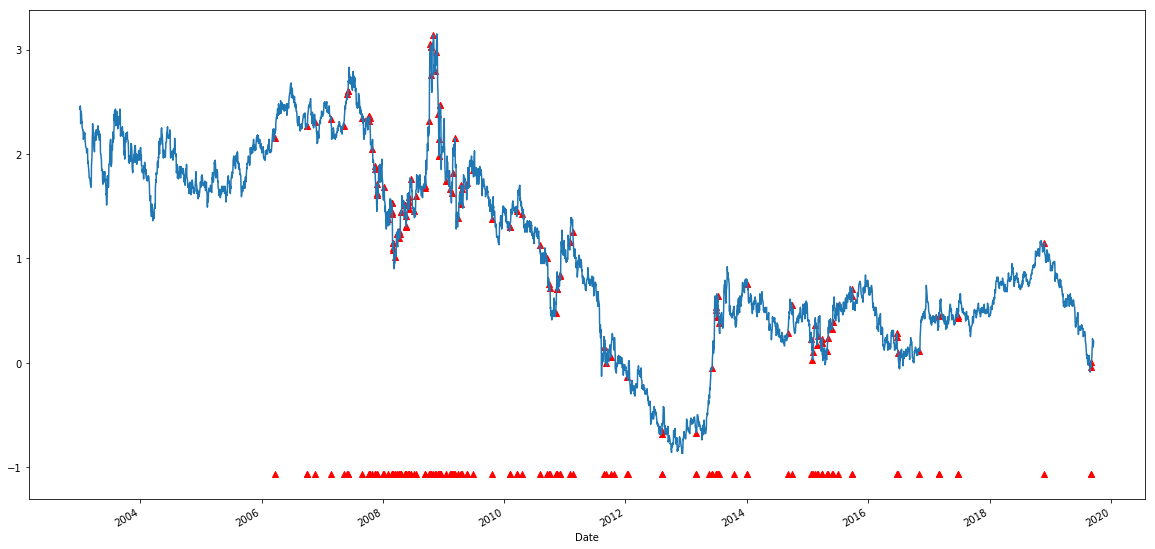

In [9]:
rate_se.plot();
display_impactful_speech(show_ratio=0.2)

## Overall reval profile 

Reval/preval analysis is a widely used tools in market impact analysis. It is defined as the price movement before and after a certain incident happens in the market. In this case study, we construct revals of 5-year treasury yield movement before and after the Fed speech. 

In [10]:
rev_lst = get_reval(rst_lst, rate_se)

/Users/Binlin/7871-NLP Project/nlp_project-master/utils.py:33: RuntimeWarning: divide by zero encountered in log
  tt = np.log(np.hstack((prev, rev)) / this)
/Users/Binlin/7871-NLP Project/nlp_project-master/utils.py:33: RuntimeWarning: invalid value encountered in log
  tt = np.log(np.hstack((prev, rev)) / this)
/Users/Binlin/7871-NLP Project/nlp_project-master/utils.py:33: RuntimeWarning: divide by zero encountered in true_divide
  tt = np.log(np.hstack((prev, rev)) / this)
/Users/Binlin/7871-NLP Project/nlp_project-master/utils.py:33: RuntimeWarning: invalid value encountered in true_divide
  tt = np.log(np.hstack((prev, rev)) / this)


In [11]:
rev_ar = np.vstack(rev_lst)

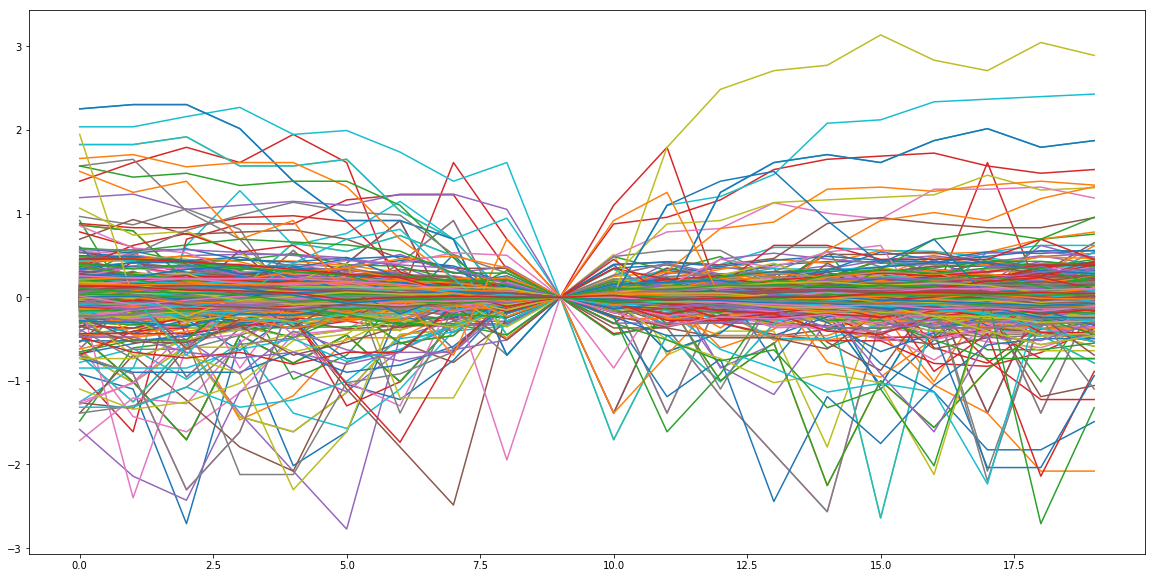

In [12]:
plt.plot(rev_ar.T);

#### As expected, the revals for most of the speeches are quite flat, while on the other hand there are several speeches that have long lasting market impact.

## A Quick Look at the Important Speeches

In [13]:
rev_ar[0]

array([-0.08186387, -0.08186387, -0.06774599, -0.06308398, -0.0355593 ,
       -0.05382465, -0.06308398, -0.03104462, -0.02655023,  0.        ,
        0.00869571,  0.00869571,  0.01301537,  0.        ,  0.02586351,
        0.02159911,  0.04274155,  0.05107493,  0.05107493,  0.03854867])

In [14]:
most_impact_article_lst = [rst_lst[i][:2] for i in np.argsort(-rev_ar[:, 12])[:10]]

In [15]:
most_impact_article_lst

[('Refining the Stress Capital Buffer', '20190905'),
 ('Challenges for Monetary Policy', '20190823'),
 ('Brief Remarks', '20160929'),
 ('Trends in Community Bank Performance over the Past 20 Years', '20160929'),
 ('Advancing Macroprudential Policy Objectives', '20150130'),
 ('Legal Opportunities and Challenges in Crafting a Foreclosure Response',
  '20111004'),
 ('Welcoming Remarks', '20150204'),
 ('Tailoring Community Bank Regulation and Supervision', '20150430'),
 ('The Economic Outlook', '20161104'),
 ('Remarks on Monetary Policy', '20150408')]

Not surprisingly, the speech before the rate cut in August, is very important.

## Feature Construction 

Here we would like to first use word bag as representation of each of the article. We also notice the titles may also be important so we should think about a method to generate features from them as well. However, intuitively, it might not be the best idea of treating the words in title and those in the passage alike.   
Here we construct features in title and passage seperately and merge the embedded vector together.

In [16]:
X = pd.DataFrame([str2word_bag(itm[2], STOP_CHARS, STOP_WORDS, to_lower=True) for itm in rst_lst]).fillna(0).values

In [17]:
X_title = pd.DataFrame([str2word_bag(itm[1], STOP_CHARS, STOP_WORDS, to_lower=True) for itm in rst_lst]).fillna(0).values

## Trading Strategy Assumptions

1. We have tradable securities for this predictive signal. 
2. We use the rate for backtesting. Here we assume the duration of such securities meerly change in the testing period (several days)

## Systematic Parameter Search and Back Testing

We understand different combination of the hyperparameter, like how to label the sample, might have diverged result to the trading strategy. Here we use a systematic grid search algo to find some reasonable parameter sets by out of sample returns.

Parameters we would like to test on including: learning_algorithm, training_set_length, target_lag, quantile_for_label

Details of this algorithm can be found in *back_test_utils.py*

Results are listed here

In [18]:
with open("param_results.pkl", "rb") as fp:
    param_rst_lst = pickle.load(fp)

with open("params_str.pkl", "rb") as fp:
    params_lst = pickle.load(fp)

In [19]:
len(param_rst_lst)

60

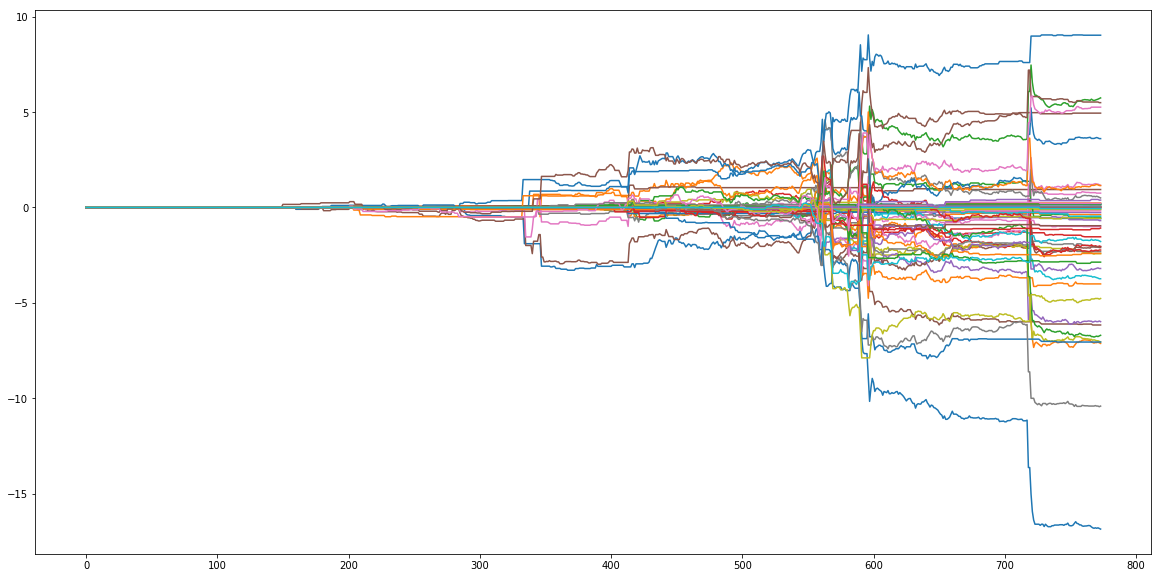

In [20]:
for idx, prd_ar in param_rst_lst:
    plt.plot(np.cumsum((rev_ar[:, 11 + 1] - rev_ar[:, 10]) * prd_ar))

## Best Parameters Sets

In [21]:
rtn_lst = []

for idx, prd_ar in param_rst_lst:
    rtn_lst.append((idx, np.cumsum((rev_ar[:, 11 + 1] - rev_ar[:, 10]) * prd_ar)[-1]))

In [22]:
rtn_lst.sort(key=lambda x: x[1], reverse=True)

In [23]:
rtn_lst[:5]

[(20, 9.02591473914862),
 (12, 5.740265669165892),
 (55, 5.49121370026334),
 (56, 5.254753906979816),
 (35, 4.941780222977251)]

In [24]:
[params for idx, params in enumerate(params_lst) if idx in [i[0] for i in rtn_lst[:5]]]

[('ExtraTreesClassifier(n_estimators=50)',
  'X_df.values',
  'get_y(rev_ar, 1, 30 / 100)',
  300),
 ('ExtraTreesClassifier(n_estimators=50)',
  'X_df.values',
  'get_y(rev_ar, 2, 20 / 100)',
  100),
 ('ExtraTreesClassifier(n_estimators=50)',
  'X_df.values',
  'get_y(rev_ar, 5, 20 / 100)',
  100),
 ('ExtraTreesClassifier(n_estimators=50)',
  'X_df.values',
  'get_y(rev_ar, 10, 30 / 100)',
  100),
 ('ExtraTreesClassifier(n_estimators=50)',
  'X_df.values',
  'get_y(rev_ar, 10, 30 / 100)',
  200)]

Counter intuitively, the titles are more noise than helpful features and the Random Forest models are uniformly better.

In [25]:
y_prd = param_rst_lst[20][1]

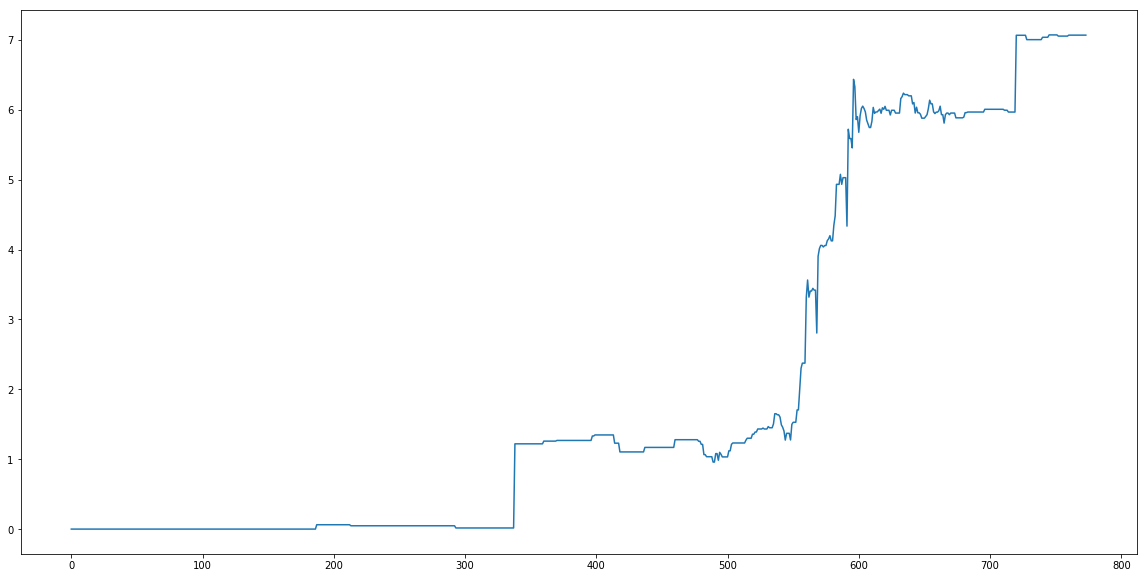

In [26]:
rtn_shift = 1

plt.plot(np.cumsum((rev_ar[:, 9 + 1 + rtn_shift] - rev_ar[:, 9 + rtn_shift]) * y_prd));

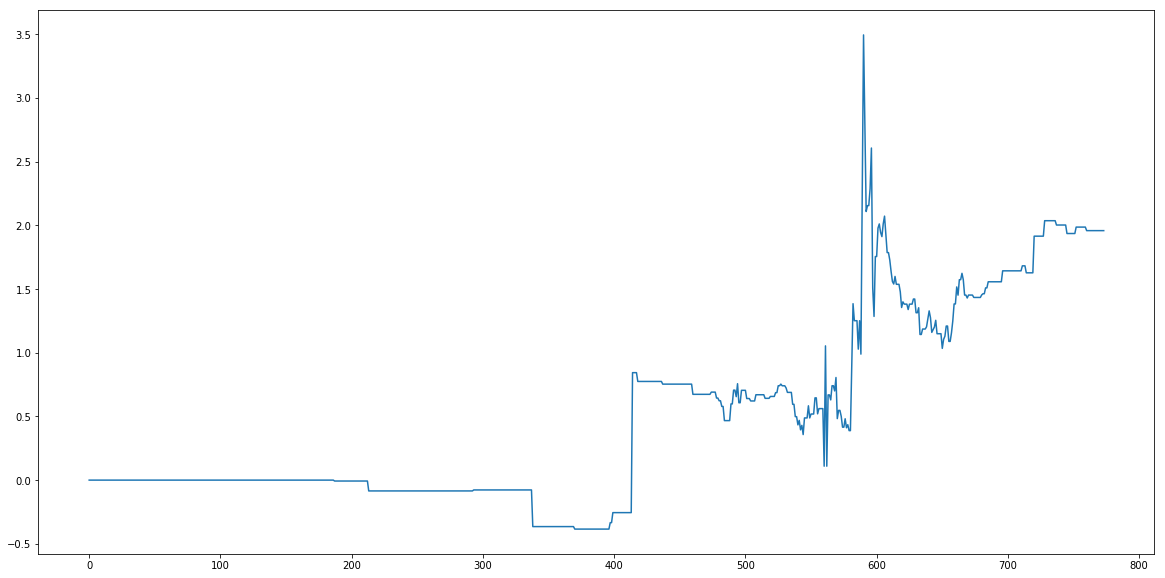

In [27]:
rtn_shift = 2

plt.plot(np.cumsum((rev_ar[:, 9 + 1 + rtn_shift] - rev_ar[:, 9 + rtn_shift]) * y_prd));

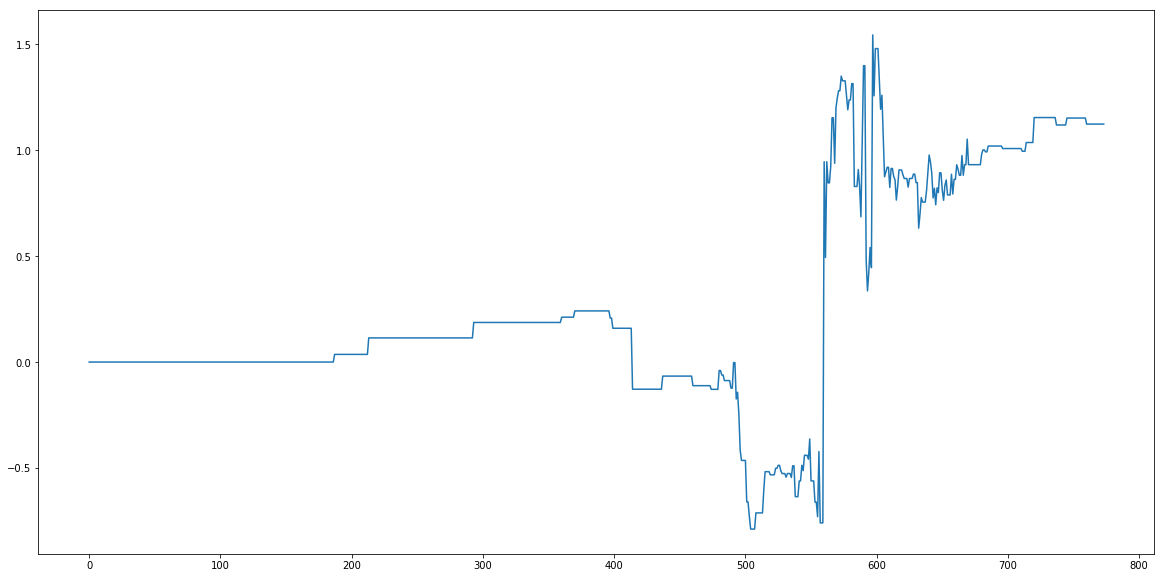

In [28]:
rtn_shift = 3

plt.plot(np.cumsum((rev_ar[:, 9 + 1 + rtn_shift] - rev_ar[:, 9 + rtn_shift]) * y_prd));

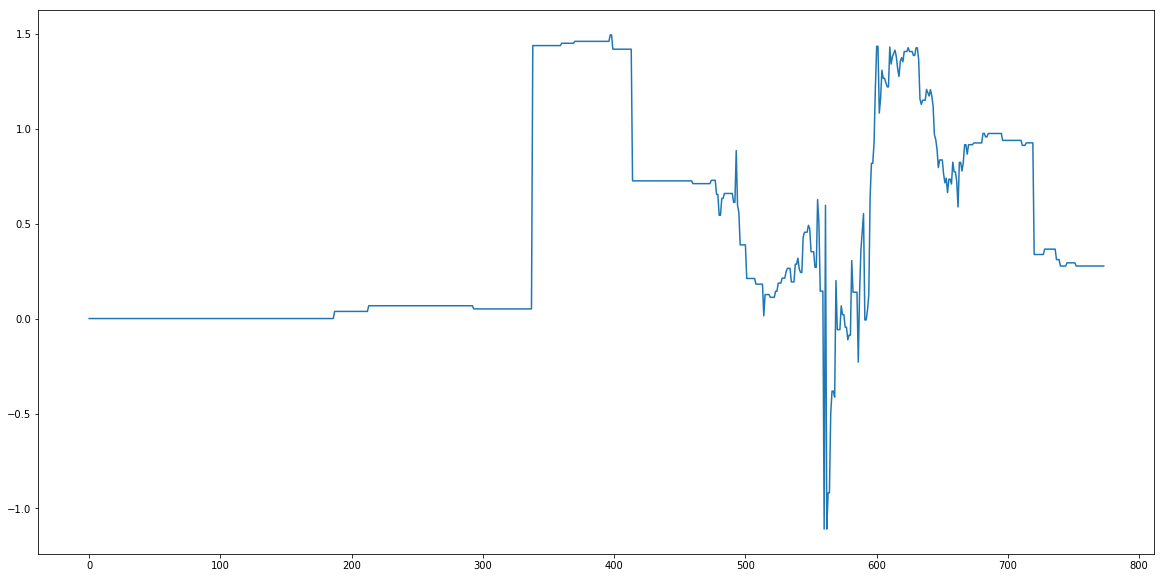

In [29]:
rtn_shift = 4

plt.plot(np.cumsum((rev_ar[:, 9 + 1 + rtn_shift] - rev_ar[:, 9 + rtn_shift]) * y_prd));

## Alpha Decay

In [30]:
mean_decay = get_alpha_decay(rev_ar, y_prd)

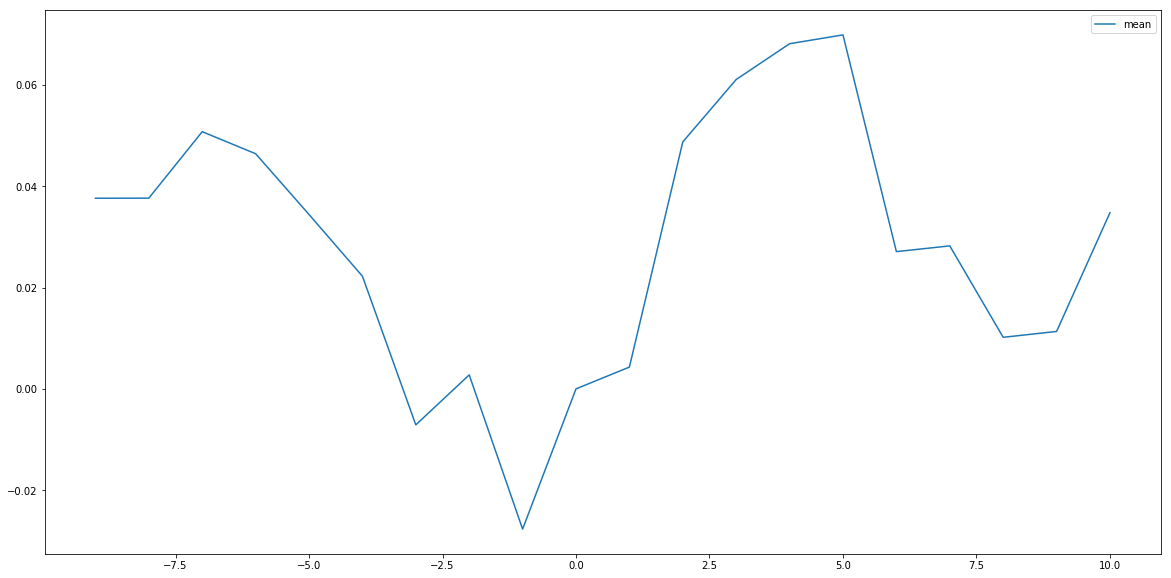

In [31]:
plt.plot(range(-9, 11), mean_decay, label="mean")
plt.legend();